In [2]:
import torch
import numpy as np
import pinot
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
# define the target
f = lambda x: torch.sin(x)

x_tr = torch.tensor(np.concatenate(
    [
        np.linspace(-3 * math.pi, -math.pi, 50),
        np.linspace(math.pi, 3 * math.pi, 50)
    ]),
    dtype=torch.float32)[:, None]

x_te = torch.tensor(np.concatenate(
    [
        np.linspace(-7 * math.pi, -3 * math.pi, 100),
        np.linspace(-math.pi, math.pi, 50),
        np.linspace(3 * math.pi, 7 * math.pi, 100)
    ]),
    dtype=torch.float32)[:, None]

x = torch.tensor(np.linspace(-7 * math.pi, 7 * math.pi, 375),
                 dtype=torch.float32)[:, None]


y_tr = f(x_tr)
y_te = f(x_te)
y = f(x)

In [10]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 50),
        torch.nn.Tanh(),
        torch.nn.Linear(50, 1))

kernel = pinot.inference.gp.deep_kernel.DeepKernel(
    net,
    base_kernel=pinot.inference.gp.kernels.RBF())

In [11]:
opt = torch.optim.Adam(net.parameters(), 1e-2)
for _ in range(1000):
    opt.zero_grad()
    loss = kernel.loss(x_tr, y_tr).sum()
    loss.backward()
    opt.step()

In [12]:
y_hat_distribution = kernel.inference(x_tr, y_tr, x)

In [13]:
def plot():
    from pinot.inference.utils import confidence_interval
    from matplotlib import pyplot as plt

    plt.figure(figsize=(10, 6))
    # y_hat_distribution = pinot.inference.utils.condition_mixture(net, x, sampler=opt, n_samples=1000)

    nll = y_hat_distribution.log_prob(y).mean() / float(y.shape[0])

    plt.plot(x, y_hat_distribution.mean.detach().numpy(), c='k', linewidth=5)

    low, high = confidence_interval(y_hat_distribution, 0.95, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.1)
    
    low, high = confidence_interval(y_hat_distribution, 0.75, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.2)

    low, high = confidence_interval(y_hat_distribution, 0.50, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.3)

    low, high = confidence_interval(y_hat_distribution, 0.25, n_samples=100)
    plt.fill_between(x.flatten(), low.flatten(), high.flatten(), color='k', alpha=0.4)

    plt.scatter(x_te, y_te, label='te')
    plt.scatter(x_tr, y_tr, label='tr')
    plt.legend()
    plt.ylim(-2, 2)
    plt.title('NLL=%s' % nll.detach().numpy().round(3))

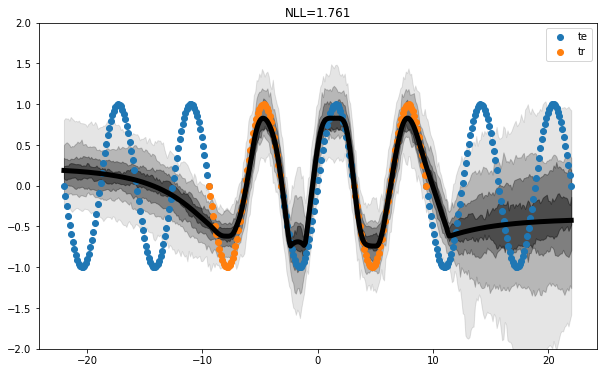

In [14]:
plot()